# Tensorflow option

> Finbar Giusti

In this notebook, I will test using a transformer network to predict these seismic events.

In [1]:
%%capture
# required libraries

%pip install numpy pandas tensorflow scikit-learn seaborn matplotlib obspy keras 

import pandas as pd
import numpy as np
import seaborn as sns
from obspy import read
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from obspy.signal.invsim import cosine_taper
from scipy.signal import welch
from obspy.signal.freqattributes import spectrum

In [30]:
import os

catalog = pd.read_csv('data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')
training_data = {}

for index, row in catalog.iterrows():
    try:
        file_path = f'data/lunar/training/data/S12_GradeA/{row.filename}.mseed'
        
        # Check if the file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        # Read the data
        data = read(file_path)
        
        # Ensure the necessary columns are present
        if 'time_rel(sec)' not in row or 'mq_type' not in row:
            raise KeyError("Missing required columns in the row data")
        
        # Add to training_data
        training_data[row.evid] = {
            'data': data,
            'rel_time': row['time_rel(sec)'],
            'type': row['mq_type']
        }
    
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except KeyError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Error: File not found: data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed


## Theory
I would like to use a transformer network to make the binary prediction of whether or not a given window contains the beginning of a seismic event. A transformer network is used as some parts of the signal are more important than others in the prediction of these events.

In [3]:
# first let's peek at a sample of the seismic events, to determine how large we should make the windows.

events = training_data.keys()

WINDOW = 10000 # 10,000 secs for training window


In [31]:
nfft = 1024  # Number of points in FFT
width = 3 

def convert_to_low_res(tr):
    minfreq = 0.5
    maxfreq = 1.0
    
    # Going to create a separate trace for the filter data
    trace = tr.copy()
    tr.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    
    # Step 2: Define your parameters
    fs = trace.stats.sampling_rate  # Sampling frequency
    n_seconds = int(trace.stats.npts / fs)  # Total number of seconds
    n_bins = 10  # Number of frequency bands
    freq_bins = np.linspace(0, fs / 2, n_bins + 1)  # Define frequency bands
    amplitudes = np.zeros((n_seconds, n_bins))  # Prepare an array to store amplitudes
    
    # Step 3: Process the data for each second
    for i in range(int(n_seconds/width)):
        start = i*width
        segment = trace.data[int(start * fs):int((start + width) * fs)]
        
        # # Apply a taper to minimize edge effects
        # taper = cosine_taper(len(segment), 0.1)  # 10% taper
        # segment *= taper
    
        # Compute the PSD using Welch's method
        f, Pxx = welch(segment, fs, nperseg=fs * width, nfft=nfft, scaling='density')
    
        # Step 4: Aggregate the data into frequency bins
        for i in range(n_bins):
            mask = (f >= freq_bins[i]) & (f < freq_bins[i + 1])
            amplitudes[start, i] = np.sqrt(np.sum(Pxx[mask]))

    return amplitudes


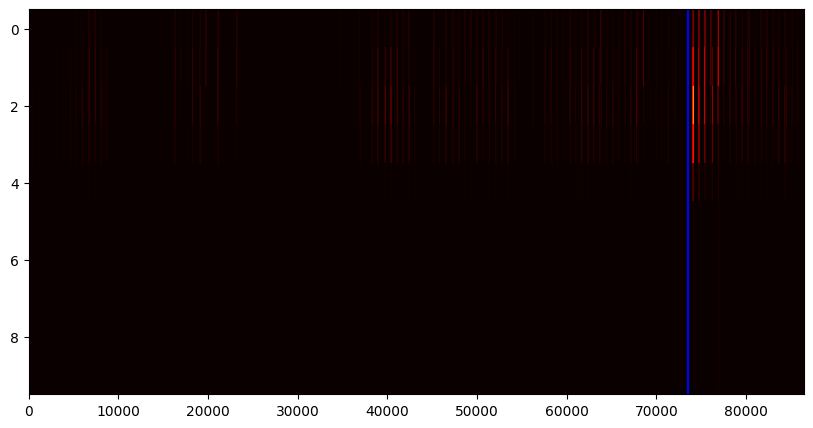

In [32]:
# lets see how this transforms the data.
sample = training_data[next(iter(events))]
example = convert_to_low_res(sample['data'][0])
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(example.T, cmap='hot', interpolation='nearest')
ax.set_aspect('auto')
ax.axvline(x = sample['rel_time'], color='blue',label='Rel. Arrival')
plt.show()

In [26]:
# lets transform these datapoints (this may take some time)

# for event in events:
#     training_data[event]['data_low_res'] = convert_to_low_res(training_data[event]['data'][0])

In [11]:
# # reflect, to save time
# for event in events:
#     np.savetxt('processed_data/low_res_' + event, training_data[event]['data_low_res'])

In [33]:
# pull from reflextion

for event in events:
    training_data[event]['data_low_res'] = np.loadtxt('processed_data/low_res_' + event)
    

Total number of events: 75


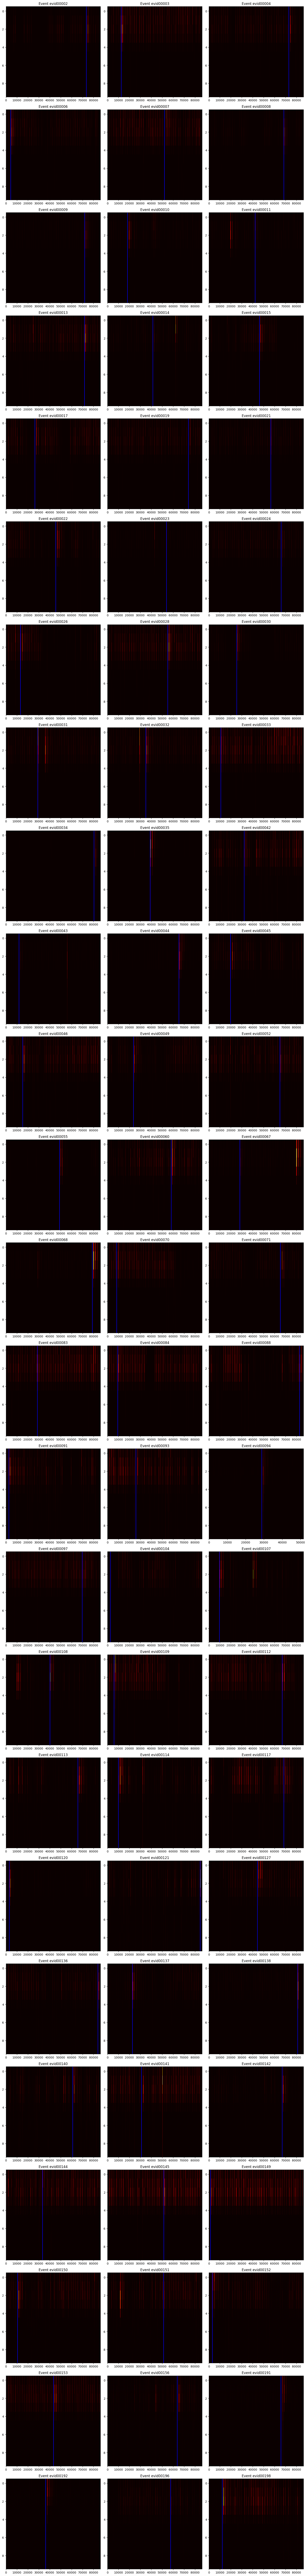

In [28]:
import matplotlib.pyplot as plt

# Check the count of events
event_count = len(events)
print(f"Total number of events: {event_count}")

# Determine the number of rows needed for the subplot grid
rows = (event_count + 2) // 3  # +2 to ensure we round up if there are leftovers

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, event in enumerate(events):
    ax = axes[i]
    ax.imshow(training_data[event]['data_low_res'].T, cmap='hot', interpolation='nearest')
    ax.set_aspect('auto')
    ax.axvline(x=training_data[event]['rel_time'], color='blue', label='Rel. Arrival')
    ax.set_title(f"Event {event}")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# for event in events:
#     fig, ax = plt.subplots(figsize=(10, 5))
#     ax.imshow(training_data[event]['data_low_res'].T, cmap='hot', interpolation='nearest')
#     ax.set_aspect('auto')
#     ax.axvline(x = training_data[event]['rel_time'], color='blue',label='Rel. Arrival')
#     plt.show()

In [14]:
# now, we can create a set of samples, based on windowed chops of each spectrum.

In [34]:
CONTEXT_SIZE = 10000
OVERLAP = 2000

def generate_samples(event):
    X = []
    Y = []
    
    data = event['data_low_res']
    event_time = event['rel_time']
    start = 0
    while start < len(data) - CONTEXT_SIZE:
        X.append(data[start:start+CONTEXT_SIZE])
        Y.append(
            1 if start <= event_time and start+CONTEXT_SIZE > event_time else 0
        )
        start += int(CONTEXT_SIZE - OVERLAP)

    return X,Y


    

In [35]:
X = []
Y = []

for event in events:
    event_X, event_Y = generate_samples(training_data[event])
    X = X + event_X
    Y = Y + event_Y



X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=69)

In [31]:
from BinaryTransformClassify import BinaryTransformClassifier 

btc = BinaryTransformClassifier(X_train.shape[1:])

history = btc.train(50, X_train, Y_train, batch_size=1)

Epoch 1/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.4652 - sparse_categorical_accuracy: 0.8964 - val_loss: 2.5272 - val_sparse_categorical_accuracy: 0.8593 - learning_rate: 0.0010
Epoch 2/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.3543 - sparse_categorical_accuracy: 0.8879 - val_loss: 12.3158 - val_sparse_categorical_accuracy: 0.8593 - learning_rate: 0.0010
Epoch 3/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.3286 - sparse_categorical_accuracy: 0.9011 - val_loss: 5.2455 - val_sparse_categorical_accuracy: 0.1407 - learning_rate: 0.0010
Epoch 4/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.3492 - sparse_categorical_accuracy: 0.8919 - val_loss: 0.6666 - val_sparse_categorical_accuracy: 0.8593 - learning_rate: 0.0010
Epoch 5/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.3801 - sparse_categorical_accuracy: 0.8749 - val_loss: 7.8599 - val_sparse_categorical_accuracy: 0.8593 - learning_rate: 0.0010
Epoch 6/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 9s 

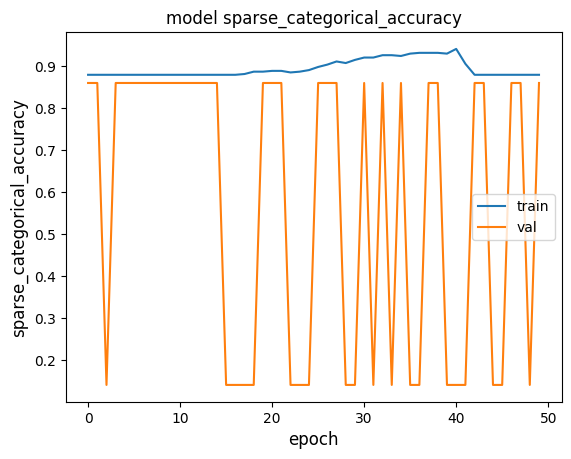

In [32]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [33]:
btc.evaluate(X_test, Y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.4413 - sparse_categorical_accuracy: 0.8920


[0.4400578737258911, 0.8933333158493042]

In [34]:
np.unique(Y_test, return_counts=True)

(array([0, 1]), array([67,  8], dtype=int64))

In [5]:
training_data['evid00002']

{'data': 1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-01-19T00:00:00.665000Z - 1970-01-20T00:00:02.778208Z | 6.6 Hz, 572415 samples,
 'rel_time': 73500.0,
 'type': 'impact_mq',
 'data_low_res': array([[1.39614550e-53, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.37377639e-49, 0.00000000e+00, 1.44382554e-48, ...,
         0.00000000e+00, 1.26190948e-49, 0.00000000e+00],
        [2.32519732e-48, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.27910084e-33, 0.00000000e+00, 4.59994192e-33, ...,
         0.00000000e+00, 1.32291524e-34, 0.00000000e+00],
        [1.47906305e-33, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.15332773e-33, 0.00000000e+00, 2.27620189e-33, ...,
         0.00000000e+00, 6.78188916e-35, 0.00000000e+00]])}

In [36]:
import numpy as np

# Initialize lists to hold features and labels
X = []
y = []

# Determine the maximum length of the feature arrays
max_length = max(training_data[event]['data_low_res'].size for event in events)

# Iterate over each event to extract features and labels
for event in events:
    # Extract the low-resolution data as features
    features = training_data[event]['data_low_res'].flatten()  # Flatten the 2D array to 1D
    
    # Pad the features array to the maximum length
    padded_features = np.pad(features, (0, max_length - features.size), 'constant')
    X.append(padded_features)
    
    # Extract the event type as the label
    label = training_data[event]['type']
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")


Feature matrix shape: (75, 864040)
Label vector shape: (75,)


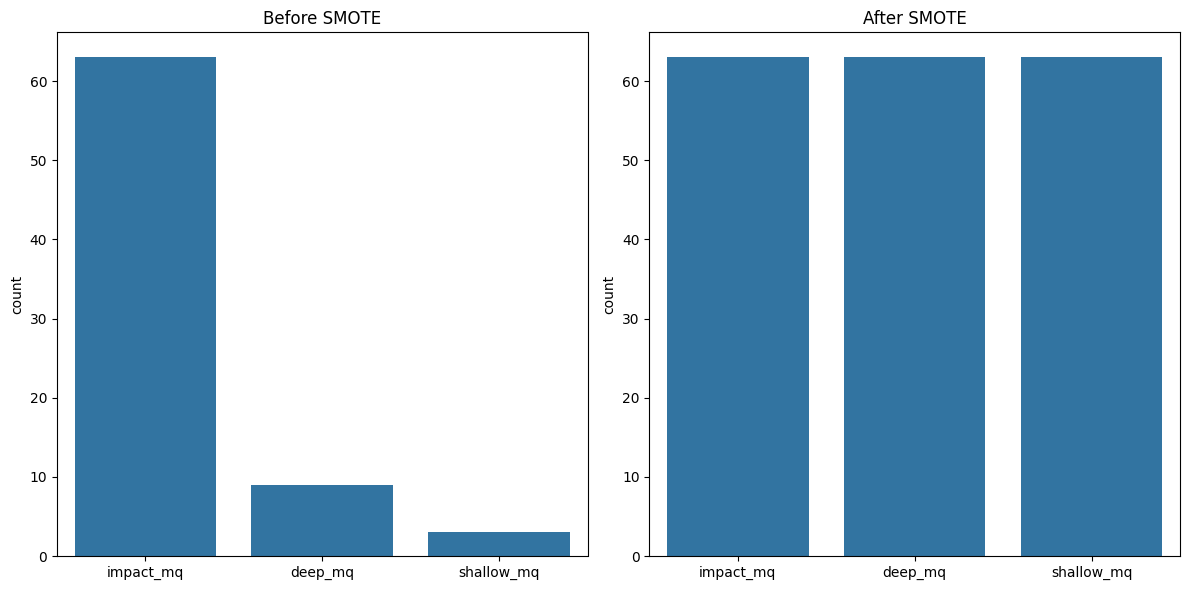

Original dataset shape: (75, 864040)
Resampled dataset shape: (189, 864040)


In [37]:
from imblearn.over_sampling import SMOTE

# Adjust the number of neighbors to be less than or equal to the number of samples in the minority class
smote = SMOTE(random_state=42, k_neighbors=2)  # Adjust k_neighbors as needed

X_smote, y_smote = smote.fit_resample(X, y)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot before SMOTE
sns.countplot(x=y, ax=ax[0])
ax[0].set_title('Before SMOTE')

# Plot after SMOTE
sns.countplot(x=y_smote, ax=ax[1])
ax[1].set_title('After SMOTE')

plt.tight_layout()
plt.show()

print(f"Original dataset shape: {X.shape}")
print(f"Resampled dataset shape: {X_smote.shape}")


In [38]:
X = np.array(X_smote)
Y = np.array(y_smote)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=21)

In [39]:
print(X_train.shape)  # Should be (num_samples, num_timesteps)
print(X_test.shape)   # Should be (num_samples, num_timesteps)

(170, 864040)
(19, 864040)


In [23]:
# Reshape the data to add the third dimension
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)

print(X_train_reshaped.shape)  # Should be (170, 864040, 1)
print(X_test_reshaped.shape)   # Should be (19, 864040, 1)

(170, 864040, 1)
(19, 864040, 1)


In [24]:
btc = BinaryTransformClassifier(X_train_reshaped.shape)

history = btc.train(50, X_train, Y_train, batch_size=1)

ValueError: Invalid dtype: str320

In [40]:
from BinaryTransformClassify import BinaryTransformClassifier 

btc = BinaryTransformClassifier(X_train.shape[1:])

history = btc.train(50, X_train, Y_train, batch_size=1)

ValueError: Input 0 of layer "conv1d_1" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 864040)

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()